In [ ]:
!nvidia-smi

Fri Jun  3 16:15:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"teoem2k","key":"6f0508fdec1ab9f9d5840bdbdb72740b"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c image-matching-challenge-2022
!kaggle datasets download -d ammarali32/kornia-loftr
!kaggle datasets download -d losveria/super-glue-pretrained-network

100% 2.31G/2.31G [00:21<00:00, 185MB/s]
100% 2.31G/2.31G [00:21<00:00, 118MB/s]
 93% 115M/124M [00:01<00:00, 107MB/s] 
100% 124M/124M [00:01<00:00, 89.7MB/s]
 97% 231M/237M [00:02<00:00, 130MB/s] 
100% 237M/237M [00:02<00:00, 99.2MB/s]


In [ ]:
%%time
%%capture
!mkdir data
!mkdir data/image-matching-challenge-2022
!mkdir data/kornia-loftr
!mkdir data/super-glue-pretrained-network

!unzip image-matching-challenge-2022.zip -d data/image-matching-challenge-2022
!unzip kornia-loftr.zip -d data/kornia-loftr
!unzip super-glue-pretrained-network.zip -d data/super-glue-pretrained-network

CPU times: user 245 ms, sys: 80.7 ms, total: 326 ms
Wall time: 30.6 s


# ***Install Libs***

In [ ]:
%%capture
dry_run = False
!pip install /content/data/kornia-loftr/kornia-0.6.4-py2.py3-none-any.whl
!pip install /content/data/kornia-loftr/kornia_moons-0.1.9-py3-none-any.whl
!pip install opencv-python==4.5.4.60

## Copy ```https://github.com/magicleap/SuperGluePretrainedNetwork/blob/master/models/superglue.py``` to ```/usr/local/lib/python3.7/site-packages/kornia/feature/loftr/utils/```

In [ ]:
# !cp '/content/data/super-glue-pretrained-network/models/superglue.py' '/usr/local/lib/python3.7/site-packages/kornia/feature/loftr/utils/'

cp: cannot create regular file '/usr/local/lib/python3.7/site-packages/kornia/feature/loftr/utils/': No such file or directory


# ***Import dependencies***

In [2]:
import os
import numpy as np
import cv2
import csv
from glob import glob
import torch
import matplotlib.pyplot as plt
import kornia
from kornia_moons.feature import *
import kornia as K
import kornia.feature as KF
import gc
import copy

# ***Model***

In [3]:
default_cfg = {'backbone_type': 'ResNetFPN',
               'resolution': (8, 2),
               'fine_window_size': 5,
               'fine_concat_coarse_feat': True,
               'resnetfpn': {'initial_dim': 128, 'block_dims': [128, 196, 256]},
               'coarse': {'d_model': 256,
                          'd_ffn': 256,
                          'nhead': 8,
                          'layer_names': ['self',
                                          'cross',
                                          'self',
                                          'cross',
                                          'self',
                                          'cross',
                                          'self',
                                          'cross'],
                          'attention': 'linear',
                          'temp_bug_fix': False},
               'match_coarse': {'thr': 0.2,
                                'border_rm': 2,
                                'match_type': 'dual_softmax',
                                'dsmax_temperature': 0.1,
                                'skh_iters': 3,
                                'skh_init_bin_score': 1.0,
                                'skh_prefilter': True,
                                'train_coarse_percent': 0.4,
                                'train_pad_num_gt_min': 200},
               'fine': {'d_model': 128,
                        'd_ffn': 128,
                        'nhead': 8,
                        'layer_names': ['self', 'cross'],
                        'attention': 'linear'}}

# dual softmax (ds)
ds_cfg = copy.deepcopy(default_cfg)
ds_cfg['match_coarse']['thr'] = 0.25
# sinkhorn (ot)
ot_cfg = copy.deepcopy(default_cfg)
ot_cfg['match_coarse']['thr'] = 0.325
ot_cfg['match_coarse']['match_type'] = 'sinkhorn'
ot_cfg['match_coarse']['sparse_spvs'] = False
ot_cfg['match_coarse']['skh_iters'] = 4

In [4]:
device = torch.device('cuda')
ds_matcher = KF.LoFTR(pretrained=None, config=ds_cfg)
ds_matcher.load_state_dict(torch.load("/content/data/kornia-loftr/outdoor_ds.ckpt")['state_dict'])
ds_matcher = ds_matcher.to(device).eval()
ot_matcher = KF.LoFTR(pretrained=None, config=ot_cfg)
ot_matcher.load_state_dict(torch.load("/content/data/kornia-loftr/outdoor_ot.ckpt")['state_dict'])
ot_matcher = ot_matcher.to(device).eval()

## *Utils*

In [5]:
src = '/content/data/image-matching-challenge-2022/'

test_samples = []
with open(f'{src}/test.csv') as f:
    reader = csv.reader(f, delimiter=',')
    for i, row in enumerate(reader):
        # Skip header.
        if i == 0:
            continue
        test_samples += [row]


def FlattenMatrix(M, num_digits=8):
    '''Convenience function to write CSV files.'''
    
    return ' '.join([f'{v:.{num_digits}e}' for v in M.flatten()])


def load_torch_image(fname, device):
    img = cv2.imread(fname)
    scale = 840 / max(img.shape[0], img.shape[1])
    w = int(img.shape[1] * scale)
    h = int(img.shape[0] * scale)
    img = cv2.resize(img, (w, h))
    img = K.image_to_tensor(img, False).float() /255.
    img = K.color.bgr_to_rgb(img)
    return img.to(device)

# ***Inference***

/usr/local/lib/python3.7/dist-packages/kornia/feature/loftr/utils/coarse_matching.py:255: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [i_ids % data['hw0_c'][1], i_ids // data['hw0_c'][1]],
/usr/local/lib/python3.7/dist-packages/kornia/feature/loftr/utils/coarse_matching.py:258: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [j_ids % 

Image: 0 | Running time: 0.9784784317016602s


/usr/local/lib/python3.7/dist-packages/kornia/feature/loftr/utils/coarse_matching.py:255: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [i_ids % data['hw0_c'][1], i_ids // data['hw0_c'][1]],
/usr/local/lib/python3.7/dist-packages/kornia/feature/loftr/utils/coarse_matching.py:258: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [j_ids % 

Image: 1 | Running time: 0.9668319225311279s


/usr/local/lib/python3.7/dist-packages/kornia/feature/loftr/utils/coarse_matching.py:255: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [i_ids % data['hw0_c'][1], i_ids // data['hw0_c'][1]],
/usr/local/lib/python3.7/dist-packages/kornia/feature/loftr/utils/coarse_matching.py:258: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [j_ids % 

Image: 2 | Running time: 1.8905959129333496s


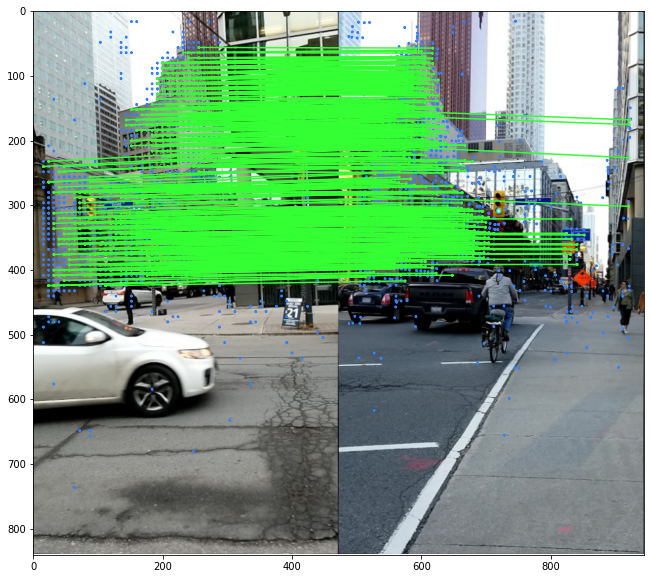

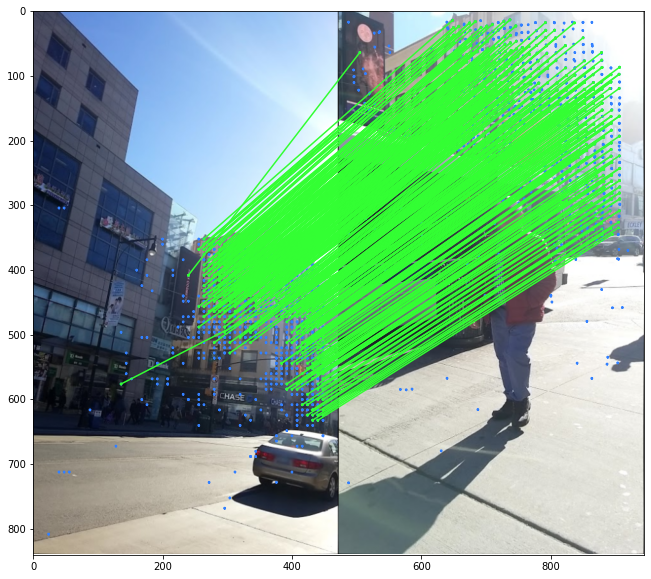

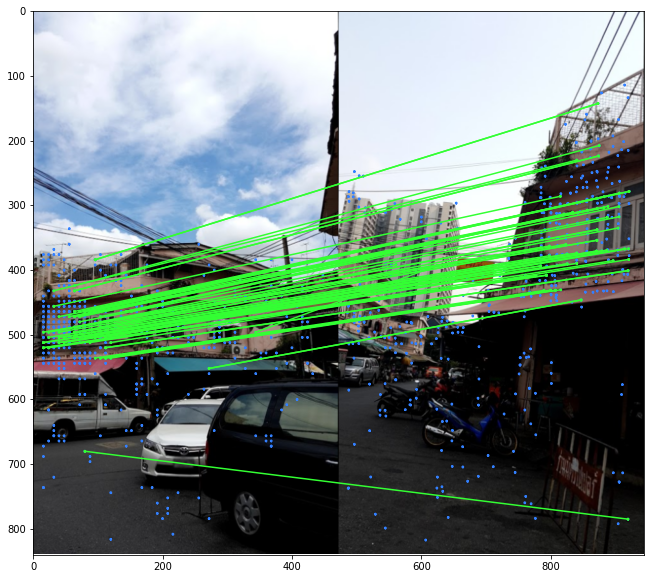

In [7]:
F_dict = {}

import time

for i, row in enumerate(test_samples):
    gc.collect()
    sample_id, batch_id, image_1_id, image_2_id = row
    # Load the images.
    st = time.time()
    image_1 =load_torch_image(f'{src}/test_images/{batch_id}/{image_1_id}.png', device)
    image_2 = load_torch_image(f'{src}/test_images/{batch_id}/{image_2_id}.png', device)
    input_dict = {"image0": K.color.rgb_to_grayscale(image_1), 
              "image1": K.color.rgb_to_grayscale(image_2)}

    with torch.no_grad():
        correspondences = ds_matcher(input_dict)

    mkpts0 = correspondences['keypoints0'].cpu().numpy()
    mkpts1 = correspondences['keypoints1'].cpu().numpy()

    del correspondences
    gc.collect()

    with torch.no_grad():
        correspondences = ot_matcher(input_dict)

    mkpts0 = np.concatenate([mkpts0, correspondences['keypoints0'].cpu().numpy()])
    mkpts1 = np.concatenate([mkpts1, correspondences['keypoints1'].cpu().numpy()])

    if len(mkpts0) > 7:
        F, inliers = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 0.2, 0.9999, 250000)
        assert F.shape == (3, 3), 'Malformed F?'
        F_dict[sample_id] = F
    else:
        F_dict[sample_id] = np.zeros((3, 3))
        continue
    if (i < 3):
        nd = time.time()    
        print(f'Image: {i+1} | Running time: {nd-st}s')
        # print("Image: ", i, " | Running time: ", nd - st, " s")
        draw_LAF_matches(
        KF.laf_from_center_scale_ori(torch.from_numpy(mkpts0).view(1,-1, 2),
                                    torch.ones(mkpts0.shape[0]).view(1,-1, 1, 1),
                                    torch.ones(mkpts0.shape[0]).view(1,-1, 1)),

        KF.laf_from_center_scale_ori(torch.from_numpy(mkpts1).view(1,-1, 2),
                                    torch.ones(mkpts1.shape[0]).view(1,-1, 1, 1),
                                    torch.ones(mkpts1.shape[0]).view(1,-1, 1)),
        torch.arange(mkpts0.shape[0]).view(-1,1).repeat(1,2),
        K.tensor_to_image(image_1),
        K.tensor_to_image(image_2),
        inliers > 0,
        draw_dict={'inlier_color': (0.2, 1, 0.2),
                   'tentative_color': None, 
                   'feature_color': (0.2, 0.5, 1), 'vertical': False})
    
with open('/content/submission.csv', 'w') as f:
    f.write('sample_id,fundamental_matrix\n')
    for sample_id, F in F_dict.items():
        f.write(f'{sample_id},{FlattenMatrix(F)}\n')